# Models Evaluation

## Confusion Matrix
It's a matrix thta summarizes all the possible outcomes of the classification. On the columns we have the actual (so, *real*) classes, whereas on the rows we have the *predicted* classes for the sample. <br>
For example, let's consider a binary classification problem where we want to distinguish between two classes: *False* and *True**. The resulting confusion matrix might look like this:

|  | Hf (Actual) | Ht (Actual) |
|---|---|---|
| **Hf (Predicted)** | 150 | 25 |
| **Ht (Predicted)** | 10 | 215 |

In this matrix:

* **150** is the number of samples that were actually False and were correctly predicted as False (**TN** for the Hf class).
* **25** is the number of samples that were actually True but were incorrectly predicted as False (**FN** for the Hf class).
* **10** is the number of samples that were actually False but were incorrectly predicted as True (**FN** for the Hf class).
* **215** is the number of samples that were actually True and were correctly predicted as True (**TP** for the Ht class).

This confusion matrix provides a clear view of how many samples were classified correctly and what types of errors the model made. <br>

Now, let's consider the **Iris** dataset, which has 3 classes. Let's import the *train/validation* split used before and fit the three Gaussian Generative Models:

In [1]:
#Import the train validation split from "./split/iris_split.npz"
import numpy as np

savedSplit = np.load('./split/iris_split.npz')

DTR = savedSplit['DTR']
DVAL = savedSplit['DVAL']
LTR = savedSplit['LTR']
LVAL = savedSplit['LVAL']

print(f"DTR shape: {DTR.shape}")
print(f"DVAL shape: {DVAL.shape}")
print(f"LTR shape: {LTR.shape}")
print(f"LVAL shape: {LVAL.shape}")

DTR shape: (4, 100)
DVAL shape: (4, 50)
LTR shape: (100,)
LVAL shape: (50,)


In [2]:
import sys
MVG_path = './models_finished/MVG'
MVGTC_path = './models_finished/MVG_TiedCov'
MVGNB_path = './models_finished/Naive_Bayes'
if not MVG_path in sys.path:
    sys.path.append(MVG_path)
if not MVGTC_path in sys.path:
    sys.path.append(MVGTC_path)
if not MVGNB_path in sys.path:
    sys.path.append(MVGNB_path)

import MVG
import MVG_TiedCov as MVGTC
import Naive_Bayes as MVGNB

### Iris Dataset, MVG Classifier Confusion Matrix Computation

In [3]:
#MVG Pipeline

def MVG_Pipeline(DTR, LTR, useLog=True):

    ML_params_MVG = MVG.computeParams_ML(DTR, LTR)


    S_LogLikelihoods_MVG = MVG.scoreMatrix_Pdf_GAU(DVAL, ML_params_MVG, useLog=useLog)
    print(f"S_LogLikelihoods_MVG shape, computed from the Validation Set: {S_LogLikelihoods_MVG.shape}")

    SJoint_MVG = MVG.computeSJoint(S_LogLikelihoods_MVG, np.ones((3, )) / 3., useLog=useLog) #compute the joint densities by multiplying the score matrix S with the Priors
    print(f"Joint densities shape: {SJoint_MVG.shape}")

    SPost_MVG = MVG.computePosteriors(SJoint_MVG, useLog=useLog) #compute the posteriors by normalizing the joint densities
    print(f"Posteriors shape: {SPost_MVG.shape}")

    PVAL_MVG = np.argmax(SPost_MVG, axis=0) #select the class with the highest posterior probability for each sample, set axis=0 to select the class with the highest posterior probability for each sample
    print(f"Predictions shape: {PVAL_MVG.shape}")
    print(f"Predictions: {PVAL_MVG}")

    return PVAL_MVG

In [4]:
PVAL_MVG = MVG_Pipeline(DTR, LTR, useLog=True)

S_LogLikelihoods_MVG shape, computed from the Validation Set: (3, 50)
Joint densities shape: (3, 50)
Posteriors shape: (3, 50)
Predictions shape: (50,)
Predictions: [0 0 1 2 2 0 0 0 1 1 0 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 2 1 0 1 2
 2 0 1 1 2 1 0 0 0 2 1 2 0]


In [5]:

#Compute confusion matrix
#classes: 0, 1, 2

Pred0_Actual0 = np.sum((PVAL_MVG == 0) & (LVAL == 0))    #True Positives for class 0
Pred0_Actual1 = np.sum((PVAL_MVG == 0) & (LVAL == 1))    #False Positives for class 0 from class 1
Pred0_Actual2 = np.sum((PVAL_MVG == 0) & (LVAL == 2))    #False Positives for class 0 from class 2

Pred1_Actual0 = np.sum((PVAL_MVG == 1) & (LVAL == 0))    #False Positives for class 0 from class 1
Pred1_Actual1 = np.sum((PVAL_MVG == 1) & (LVAL == 1))    #True Positives for class 1
Pred1_Actual2 = np.sum((PVAL_MVG == 1) & (LVAL == 2))    #False Positives for class 1 from class 2

Pred2_Actual0 = np.sum((PVAL_MVG == 2) & (LVAL == 0))    #False Positives for class 0 from class 2
Pred2_Actual1 = np.sum((PVAL_MVG == 2) & (LVAL == 1))    #False Positives for class 1 from class 2
Pred2_Actual2 = np.sum((PVAL_MVG == 2) & (LVAL == 2))    #True Positives for class 2

#confMatrix is populated manually since I have compute all the values in the confusion matrix
ConfMatrix_MVG_manual = np.array([[Pred0_Actual0, Pred0_Actual1, Pred0_Actual2],
                       [Pred1_Actual0, Pred1_Actual1, Pred1_Actual2],
                       [Pred2_Actual0, Pred2_Actual1, Pred2_Actual2]])

print(f"Confusion Matrix:\n{ConfMatrix_MVG_manual}")

Confusion Matrix:
[[19  0  0]
 [ 0 15  0]
 [ 0  2 14]]


In [6]:
def computeConfMatrix(PVAL, LVAL):
    """
    Compute the confusion matrix for the predicted labels and the actual labels.
    Args:
    - PVAL: Predicted labels
    - LVAL: Actual labels
    Returns:
    - Confusion matrix
    """
    numClasses = np.unique(LVAL).shape[0] #number of classes
    ConfMatrix = np.zeros((numClasses, numClasses)) #initialize the confusion matrix with zeros

    for classPredicted in range(numClasses):
        #for each class find the tre positives and ALL the false negatives

        classRow = np.array([]) #initialize the classRow with an empty array

        for classActual in range(numClasses):
            if classActual == classPredicted: 
                TP = np.sum((PVAL == classPredicted) & (LVAL == classPredicted))
                classRow = np.append(classRow, TP)
                continue

            #compute each FP for each wrongly assigned label
            FPi = np.sum((PVAL == classPredicted) & (LVAL == classActual))

            #add FPi to the classCol
            classRow = np.append(classRow, FPi)

        
        #add classCol to the confusion matrix in a row major fashion
        ConfMatrix[classPredicted, :] = classRow


    return ConfMatrix

In [7]:
confMatrix_MVG = computeConfMatrix(PVAL_MVG, LVAL)
print(f"Confusion Matrix, MVG Classifier:\n{confMatrix_MVG}")

Confusion Matrix, MVG Classifier:
[[19.  0.  0.]
 [ 0. 15.  0.]
 [ 0.  2. 14.]]


### Iris Dataset, Tied Covariance MVG Classifier Confusion Matrix Computation

In [8]:
#MVGTC Pipeline

def MVTC_Pipeline(DTR, LTR, useLog=True):
    ML_params_MVGTC = MVGTC.computeParams_ML_TiedCov(DTR, LTR, useLDAForTiedCov=True)

    S_LogLikelihoods_MVGTC = MVGTC.scoreMatrix_Pdf_GAU(DVAL, ML_params_MVGTC, useLog=useLog)
    print(f"S_LogLikelihoods_MVGTC shape, computed from the Validation Set: {S_LogLikelihoods_MVGTC.shape}")

    SJoint_MVGTC = MVGTC.computeSJoint(S_LogLikelihoods_MVGTC, np.ones((3, )) / 3., useLog=useLog) #compute the joint densities by multiplying the score matrix S with the Priors
    print(f"Joint densities shape: {SJoint_MVGTC.shape}")

    SPost_MVGTC = MVGTC.computePosteriors(SJoint_MVGTC, useLog=useLog) #compute the posteriors by normalizing the joint densities
    print(f"Posteriors shape: {SPost_MVGTC.shape}")

    PVAL_MVGTC = np.argmax(SPost_MVGTC, axis=0) #select the class with the highest posterior probability for each sample, set axis=0 to select the class with the highest posterior probability for each sample
    print(f"Predictions shape: {PVAL_MVGTC.shape}")
    print(f"Predictions: {PVAL_MVGTC}")

    return PVAL_MVGTC


In [9]:
confMatrix_MVGTC = computeConfMatrix(MVTC_Pipeline(DTR, LTR), LVAL)
print(f"\nConfusion Matrix, Tied Cov MVG Classifier:\n{confMatrix_MVGTC}")

S_LogLikelihoods_MVGTC shape, computed from the Validation Set: (3, 50)
Joint densities shape: (3, 50)
Posteriors shape: (3, 50)
Predictions shape: (50,)
Predictions: [0 0 1 2 2 0 0 0 1 1 0 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 1 0 1 2
 2 0 1 1 2 1 0 0 0 2 1 2 0]

Confusion Matrix, Tied Cov MVG Classifier:
[[19.  0.  0.]
 [ 0. 16.  0.]
 [ 0.  1. 14.]]


### Iris Dataset, Naive Bayes MVG Classifier Confusion Matrix Computation

In [10]:
#Naive Bayes Pipeline

def MVGNB_Pipeline(DTR, LTR, useLog=True):

    ML_params_MVGNB = MVGNB.computeParams_ML_NaiveBayesAssumption(DTR, LTR)

    S_LogLikelihoods_MVGNB = MVGNB.scoreMatrix_Pdf_GAU(DVAL, ML_params_MVGNB, useLog=True)
    print(f"S_LogLikelihoods_MVGNB shape, computed from the Validation Set: {S_LogLikelihoods_MVGNB.shape}")

    SJoint_MVGNB = MVGNB.computeSJoint(S_LogLikelihoods_MVGNB, np.ones((3, )) / 3., useLog=True) #compute the joint densities by multiplying the score matrix S with the Priors
    print(f"Joint densities shape: {SJoint_MVGNB.shape}")

    SPost_MVGNB = MVGNB.computePosteriors(SJoint_MVGNB, useLog=True) #compute the posteriors by normalizing the joint densities
    print(f"Posteriors shape: {SPost_MVGNB.shape}")

    PVAL_MVGNB = np.argmax(SPost_MVGNB, axis=0) #select the class with the highest posterior probability for each sample, set axis=0 to select the class with the highest posterior probability for each sample
    print(f"Predictions shape: {PVAL_MVGNB.shape}")
    print(f"Predictions: {PVAL_MVGNB}")

    return PVAL_MVGNB

In [11]:
confMatrix_MVGNB = computeConfMatrix(MVGNB_Pipeline(DTR, LTR), LVAL)
print(f"\nConfusion Matrix, Naive Bayes MVG Classifier:\n{confMatrix_MVGNB}")

S_LogLikelihoods_MVGNB shape, computed from the Validation Set: (3, 50)
Joint densities shape: (3, 50)
Posteriors shape: (3, 50)
Predictions shape: (50,)
Predictions: [0 0 1 2 2 0 0 0 1 1 0 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 2 0 1 2
 2 0 1 1 2 1 0 0 0 2 1 2 0]

Confusion Matrix, Naive Bayes MVG Classifier:
[[19.  0.  0.]
 [ 0. 15.  0.]
 [ 0.  2. 14.]]


Given the limited number of errors, a detailed analysis of the IRIS dataset is not very interesting. We
thus turn our attention to a larger evaluation dataset. <br>
We can use the dataset used in Lab7, storing the tercets samples of the *Divina Commedia*. Each tercet is associated to a label that denotes the cantica from where tercet is extracted ($0$: *Inferno*, $1$ = *Purgatorio*, $2$ = *Paradiso*):

In [12]:
commedia_ll = np.load("./data/commedia_ll.npy")
commedia_labels = np.load("./data/commedia_labels.npy")

In [13]:
print(f"commedia_ll shape: {commedia_ll.shape}")
print(f"commedia_labels shape: {commedia_labels.shape}")
print(f"First 10 logLikelihoods of Inferno: {commedia_ll[0, :10]}")
print(f"First 10 labels: {commedia_labels[:10]}")

commedia_ll shape: (3, 1204)
commedia_labels shape: (1204,)
First 10 logLikelihoods of Inferno: [-122.72443339 -133.30648701 -134.36987251 -170.65723182 -163.97348133
 -139.39515141 -166.71004347 -174.57737603 -147.62396153 -123.47570192]
First 10 labels: [0 0 0 0 0 0 0 0 0 0]


Let's create a new function that computes the confusionMatrix given the log-likelihoods and the Priors. The classification rule used is always the maximum Posterior class probability Decisions:

In [14]:
#always import MVG before using this function!

def computeConfMatrixFromLL(LVAL, logLikelihoods, Priors, useLog=True):
    """
    Compute the confusion matrix for the predicted labels and the actual labels.
    Args:
    - logLikelihoods: matriix of log likelihoods for each class
    - Priors: array of priors for each class, priors are application dependent
    - useLog: if True, use log likelihoods, else use normal likelihoods

    Returns:
    - Confusion matrix
    """

    SJoint = MVG.computeSJoint(logLikelihoods, Priors, useLog=useLog) #compute the joint densities by multiplying the score matrix S with the Priors
    SPost = MVG.computePosteriors(SJoint, useLog=True)  #compute the posteriors by normalizing the joint densities
    PVAL = np.argmax(SPost, axis=0) #select the class with the highest posterior probability for each sample, set axis=0 to select the class with the highest posterior probability for each sample

    #call the computeConfMatrix function to compute the confusion matrix
    return computeConfMatrix(PVAL, LVAL)
    

For computing the Confusion Matrix for the *Commedia* dataset, we assume uniform Priors for each cantica: $P(l\_lInf) = P(l\_lPur) = P(l\_lPar) = \frac{1}{3}$

In [15]:
#Compute the confusion matrix for the log likelihoods
#Assume uniform priors for each class

confMatrix_Commedia = computeConfMatrixFromLL(commedia_labels, commedia_ll, np.ones((3, )) / 3., useLog=True)
print(f"\nConfusion Matrix, Commedia Classifier:\n{confMatrix_Commedia}")


Confusion Matrix, Commedia Classifier:
[[210. 113.  61.]
 [137. 191. 111.]
 [ 53.  98. 230.]]


## Optimal Bayes decision
The goal of a classifier is to allow us to choose an action $a$ to perform among
a set of actions $\mathcal{A}$. In the context of classification, an action can be simply "Classify sample $x_t$ with label $k$", although we can have also more complex types of actions. <br> 
We can associate to each action a **cost** $C(a \mid k)$ that we have to pay when we choose action $a$ and the sample belongs to class $k$. This can be seen as a missclassification cost, which depends both on the actual and predicted class. <br>
Unluckily, at evaluation time we don't know the actual classes of the samples (what whould the point of classification be, otherwise?), but we have access to the Priors and we can calculate the Posteriors. These are useful to compute the costs. <br>
For a $K$-class problem (where classes are numbered from $0$ up to $K-1$), let's denote the Priors as:
$$
\pi = \begin{bmatrix} \pi_0 \\ \vdots \\ \pi_{K-1} \end{bmatrix}
$$
We can compute the class Posteriors, conditioned on the **Recognizer** $\mathcal{R}$ that was used to compute them (the Recognizer is our Classifier) by applying Bayes' theorem. This involves expressing the Joint probability in terms of the Likelihood of the data given the class and the Prior probability of the class. The Posterior probability is then obtained by normalizing these terms by the sum over all possible classes:
$$
P(C = c | x, \mathcal{R}) = \frac{f_{X|C,\mathcal{R}}(x|c)\pi_c}{\sum_{k=0}^{K-1} f_{X|C,\mathcal{R}}(x|k)\pi_k}
$$
These class Posteriors are conditioned on the Recognizer because they represent the **believes** that the Recognizer has about each sample belonging to a class $k$. We can compute the **Expected Cost** that we'll pay, according to these believes (which are the best of our knowledge at evaluation time):
$$
C_{X, \mathcal{R}}(a) = \mathop{\mathbb{E}} \left[ C(a \mid k) \mid x, \mathcal{R}\right] = \sum_{k=0}^{K-1} P(C = k \mid x, \mathcal{R}) C(a \mid k)
$$
where:
- $a$ is the action
- $k$ is the class
- $x$ is the test sample
- $\mathcal{R}$ is the Recognizer, so the Classifier

So in practice we calculate the Posteriors according to the Recognizer, and then we multiply them by the Cost of taking action $a$ given class $k$. The Expected Cost is obatined by summing this quantity all over all classes, from $0$ to $K-1$. <br>
Regarding the costs $ C(a \mid k)$, we can define the **cost matrix** as: 
$$
\mathbf{C} = \begin{bmatrix}
0 & C_{0,1} & \cdots & C_{0,K-1} \\
C_{1,0} & 0 & \cdots & C_{1,K-1} \\
\vdots & \vdots & \ddots & \vdots \\
C_{K-1,0} & C_{K-1,1} & \cdots & 0
\end{bmatrix}
$$
where $C_{i,j}$ represents the cost of predicting class $i$ when the actual class is $j$. <br>

-------------------------
## Example: Rain vs. Clear Classification

For example, let's consider a binary classification problem where the possible classes are "Rain" and "Clear".

**Confusion Matrix**

The confusion matrix is a table that summarizes the performance of a classification model. For our two classes, it would look like this:

$$
\text{Confusion Matrix} = \begin{bmatrix}
\text{True Positive (TP)} & \text{False Positive (FP)} \\
\text{False Negative (FN)} & \text{True Negative (TN)}
\end{bmatrix}
= \begin{bmatrix}
\text{Predicted Rain | Actual Rain} & \text{Predicted Rain | Actual Clear} \\
\text{Predicted Clear | Actual Rain} & \text{Predicted Clear | Actual Clear}
\end{bmatrix}
$$

Where:

* **TP (True Positive):** The number of times the model correctly predicted "Rain" when it was actually raining.
* **FP (False Positive):** The number of times the model incorrectly predicted "Rain" when it was actually "Clear" (also known as a Type I error).
* **FN (False Negative):** The number of times the model incorrectly predicted "Clear" when it was actually raining (also known as a Type II error).
* **TN (True Negative):** The number of times the model correctly predicted "Clear" when it was actually clear.

**Cost Matrix**

The cost matrix defines the cost associated with each type of prediction outcome. Let's assume the following costs:

* Correctly predicting "Rain" (TP) has no cost: 0
* Incorrectly predicting "Rain" when it's "Clear" (FP) has a cost of 1 (e.g., inconvenience of carrying an umbrella unnecessarily).
* Incorrectly predicting "Clear" when it's raining (FN) has a higher cost of 5 (e.g., getting caught in the rain without an umbrella).
* Correctly predicting "Clear" (TN) has no cost: 0

Based on these costs, the cost matrix would be:

$$
\mathbf{C} = \begin{bmatrix}
C_{\text{Predicted Rain, Actual Rain}} & C_{\text{Predicted Rain, Actual Clear}} \\
C_{\text{Predicted Clear, Actual Rain}} & C_{\text{Predicted Clear, Actual Clear}}
\end{bmatrix}
= \begin{bmatrix}
0 & 1 \\
5 & 0
\end{bmatrix}
$$

Here:

* $C_{0,0} = 0$: Cost of predicting "Rain" (index 0) when the actual class is "Rain" (index 0).
* $C_{0,1} = 1$: Cost of predicting "Rain" (index 0) when the actual class is "Clear" (index 1).
* $C_{1,0} = 5$: Cost of predicting "Clear" (index 1) when the actual class is "Rain" (index 0).
* $C_{1,1} = 0$: Cost of predicting "Clear" (index 1) when the actual class is "Clear" (index 1).

-------------------------


The optimal Bayes decision consists in predicting the class $c^*$ which has minimum expected Bayes cost:
$$
c^* = argmin_c \{ C_{X, \mathcal{R}}(a) \}
$$

## Binary task: optimal decisions
Now let's consider **binary tasks** in which we have two classes, that can always be summarized as class *True* - $H_T$ - and class *False* -$H_F$. In this case the cost matrix is always:
$$
\mathbf{C} = \begin{bmatrix}
C_{\text{Predicted } H_F \text{, Actual } H_F} & C_{\text{Predicted } H_F \text{, Actual } H_T} \\
C_{\text{Predicted } H_T   \text{, Actual } H_F} & C_{\text{Predicted } H_T \text{, Actual } H_T}
\end{bmatrix}
= \begin{bmatrix}
C(H_F \mid H_F) & C(H_F \mid H_T) \\
C(H_T \mid H_F) & C(H_T \mid H_T)
\end{bmatrix}
= \begin{bmatrix}
C_{tn} & C_{fn} \\
C_{fp} & C_{tp}
\end{bmatrix}
$$
The cost for predicting the right class is of course zero so we can rewrite the matrix as:
$$
\mathbf{C} = \begin{bmatrix}
0 & C_{fn} \\
C_{fp} & 0
\end{bmatrix}
$$
So, applying the formula, the expected Bayes costs for predicting either of the two
classes are:
$$
C_{x,\mathcal{R}}(H_F) = C (H_F \mid H_F) P(C = H_F | x, \mathcal{R}) + C (H_F \mid H_T) P(C = H_T | x, \mathcal{R}) = C_{fn}P(C = H_T | x, \mathcal{R}) \\
C_{x,\mathcal{R}}(H_T) = C (H_T \mid H_F) P(C = H_F | x, \mathcal{R}) + C (H_T \mid H_T) P(C = H_T | x, \mathcal{R}) = C_{fp}P(C = H_F | x, \mathcal{R})
$$
We predict the class $c^*$ that has minimum cost: $c^* = argmin_c \{ C_{X, \mathcal{R}}(c) \}$ <br>
For the binary task, we can also
express $c^*$ taking into account the logarithm of the two costs:
$$
c^* =
\begin{cases}
    H_T & \text{if } \log \frac{C_{fn} P(C = H_T | x, \mathcal{R})}{C_{fp} P(C = H_F | x, \mathcal{R})} > 0 \\ \\
    H_F & \text{if } \log \frac{C_{fn} P(C = H_T | x, \mathcal{R})}{C_{fp} P(C = H_F | x, \mathcal{R})} \le 0
\end{cases}
$$
If $\mathcal{R}$ is a Generative Model, we can factorize the class Posteriors into Likelihoods and Priors:

$$
c^* =
\begin{cases}
    H_T & \text{if } \log \frac{\pi_{H_T} C_{fn} f_{X|C,\mathcal{R}}(x|H_T)}{(1-\pi_{H_T}) C_{fp} f_{X|C,\mathcal{R}}(x|H_F)} > 0 \\ \\
    H_F & \text{if } \log \frac{\pi_{H_T} C_{fn} f_{X|C,\mathcal{R}}(x|H_T)}{(1-\pi_{H_T}) C_{fp} f_{X|C,\mathcal{R}}(x|H_F)} \le 0
\end{cases}
$$
Where $\pi_{H_T} = P(C = H_T)$ and $1 - \pi_{H_T} = P(C = H_F)$ are the two Priors. <br>
By recalling that the ratio between the two likelihoods is the **log-likelihood ratio** - $\text{llr}(x)$ - and the ratio between the Priors is the **Prior log odds**, we can compare the $\text{llr}(x)$, acting a a **Score**, to the other quantities, that act as a **Threshold**:

$$
c^* =
\begin{cases}
    H_T & \text{if } \text{llr}(x) = \log \frac{f_{X|C,\mathcal{R}}(x|H_T)}{f_{X|C,\mathcal{R}}(x|H_F)} > t = - \log \frac{\pi_{H_T} C_{fn}}{(1- \pi_{H_T}) C_{fp}} \\ \\
    H_F & \text{if } \text{llr}(x) = \log \frac{f_{X|C,\mathcal{R}}(x|H_T)}{f_{X|C,\mathcal{R}}(x|H_F)} \le t = - \log \frac{\pi_{H_T} C_{fn}}{(1- \pi_{H_T}) C_{fp}}
\end{cases}
$$
Where here the Threshold takes into account both Priors (defined by $\pi_{H_T}$ and $1-\pi_{H_T}$) and Costs of Errors (which are $C_{fp}$, $C_{fn}$). <br> <br>
The *triplet* $\left( \pi_{H_T}, C_{fp}, C_{fn}\right)$ denotes the **application**: since these three values are specific to the problem we're trying to solve, they define the specific application or context of the decision-making process.



In practice, We now consider the binary Inferno-vs-Paradiso task of Laboratory 7. The
classifier output consists of an array of log-likelihood ratios. <br>
In the following we assume that label $H_T$ ( $= 1$) corresponds to the Inferno and $H_F$ ( $= 0$) to the Paradiso class. <br>
We load the log-likelihood ratios and the corresponding labels:


In [16]:
classLabels = {1: "Inferno", 0: "Paradiso"}

llr_infPar = np.load("./data/commedia_llr_infpar.npy")
print(f"llr_infPar shape: {llr_infPar.shape}")
print(f"First 10 llrs: {llr_infPar[:10]}")
labels_infPar = np.load("./data/commedia_labels_infpar.npy")
print(f"labels_infPar shape: {labels_infPar.shape}")
print(f"First 10 labels: {labels_infPar[:10]}")

llr_infPar shape: (802,)
First 10 llrs: [  4.2039284   17.54979113   0.91415981  -0.35165995 -14.57430471
   5.20594261  11.28093875  -3.64766372  10.94927909  -5.3347926 ]
labels_infPar shape: (802,)
First 10 labels: [1 1 1 1 1 1 1 1 1 1]


Now the goal is to write a function that computes optimal Bayes decisions for different priors and costs starting from binary
log-likelihood ratios. The function should receive the triplet $\left( \pi_{H_T}, C_{fp}, C_{fn}\right)$, corresponding to the cost
matrix: 
$$
\mathbf{C} = \begin{bmatrix}
0 & C_{fn} \\
C_{fp} & 0
\end{bmatrix}
$$


In [17]:

#function computeConfMatrix must be imported before using this function!
def optimalBayesDecisionClassifier(llrs, LVAL, PriorTrue, Cfn, Cfp):
    """
    Compute the optimal Bayes decision for a given prior and cost function.
    And perform classification obtaining a confusion matrix.
    Args:
    - llrs: log likelihood ratios
    - LVAL: actual labels
    - PriorTrue: Prior probability of the true class
    - Cfn: Cost of false negative
    - Cfp: Cost of false positive
    Returns:
    - Confusion matrix
    - Optimal decision threshold
    """

    #compute optimal threshold
    t = -1 * np.log((PriorTrue * Cfn) / ((1 - PriorTrue) * Cfp))


    #Classification rule: if llr > t, classify as 1, else classify as 0
    PVAL = np.where(llrs > t, 1, 0)


    #compute confusion matrix
    return computeConfMatrix(PVAL, LVAL), t





    

Let's test the function we've created with four different test sets:

In [18]:
#Test the classification with four different sets of params

PriorsSet = [0.5, 0.8, 0.5, 0.8]
CfnSet = [1, 1, 10, 1]
CfpSet = [1, 1, 1, 10]


for testIndex in range(len(PriorsSet)):

    confMatrix_test, Threshold_test = optimalBayesDecisionClassifier(llr_infPar, labels_infPar, PriorsSet[testIndex], CfnSet[testIndex], CfpSet[testIndex])
    print(f"\nConfusion Matrix, Commedia infPar Binary Classifier, Test {testIndex}:\n{confMatrix_test}")
    print(f"Optimal Threshold: {Threshold_test}")


Confusion Matrix, Commedia infPar Binary Classifier, Test 0:
[[293.  96.]
 [109. 304.]]
Optimal Threshold: -0.0

Confusion Matrix, Commedia infPar Binary Classifier, Test 1:
[[271.  80.]
 [131. 320.]]
Optimal Threshold: -1.3862943611198908

Confusion Matrix, Commedia infPar Binary Classifier, Test 2:
[[257.  75.]
 [145. 325.]]
Optimal Threshold: -2.302585092994046

Confusion Matrix, Commedia infPar Binary Classifier, Test 3:
[[302. 113.]
 [100. 287.]]
Optimal Threshold: 0.9162907318741548


Let's analyze the relations between the parameters of the triplet and the values displayed in the confusion matrix:

C:\Users\Utente\AppData\Local\Temp\ipykernel_8792\4091664869.py:18: RuntimeWarning: divide by zero encountered in log
  t = -1 * np.log((PriorTrue * Cfn) / ((1 - PriorTrue) * Cfp))
C:\Users\Utente\AppData\Local\Temp\ipykernel_8792\4091664869.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  t = -1 * np.log((PriorTrue * Cfn) / ((1 - PriorTrue) * Cfp))


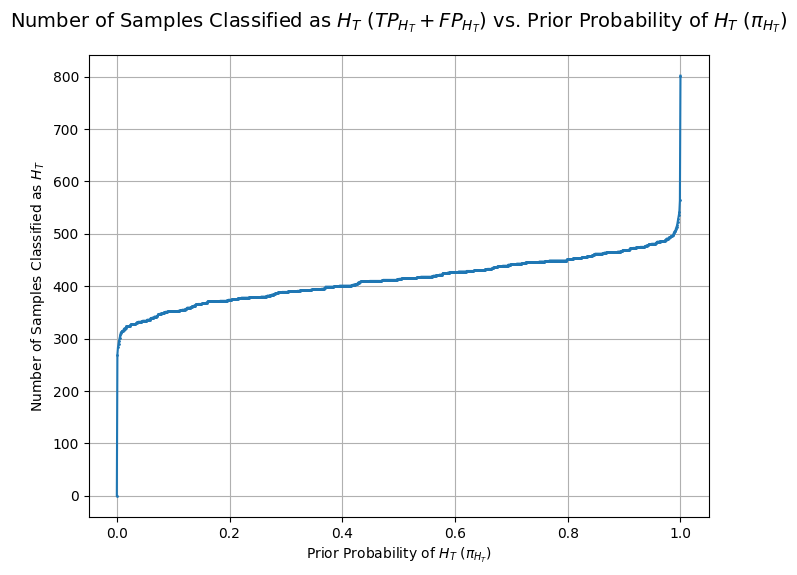

In [19]:
#chart of samples classified as H_T (Inferno) depending on the Priors \pi_H_T
import matplotlib.pyplot as plt

priorsSpace = np.linspace(0, 1, 1000)

n_H_T_classified = []

for i, prior in enumerate(priorsSpace):
    confM, _ = optimalBayesDecisionClassifier(llr_infPar, labels_infPar, prior, 1, 1)
    #extract the TP+FP from the confusion matrix to see the total number of samples classified as H_T (Inferno)
    n_H_T_classified.append(confM[1, 1] + confM[1, 0])  #True Positives + False Positives for class H_T (Inferno)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(priorsSpace, n_H_T_classified, marker='o', linestyle='-', markersize=1)
plt.title("Number of Samples Classified as $H_T$ ($TP_{H_T} + FP_{H_T}$) vs. Prior Probability of $H_T$ ($\pi_{H_T}$)", pad=20, fontsize=14)
plt.xlabel("Prior Probability of $H_T$ ($\pi_{H_T}$)")
plt.ylabel("Number of Samples Classified as $H_T$")
plt.grid(True)
plt.show()



There are two jumps: one where $\pi_{H_T} = 0$ and the other where $\pi_{H_T} = 1$: <br>
- If $\pi_{H_T} = 0$ we end up having $t = - \log \frac{\pi_{H_T} C_{fn}}{(1- \pi_{H_T}) C_{fp}}\mid _{\pi_{H_T} = 0} = - \log 0 = \log \infty = \infty  \Rightarrow \\ \\ \Rightarrow c^* =
\begin{cases}
    H_T & \text{if } \text{llr}(x) = \log \frac{f_{X|C,\mathcal{R}}(x|H_T)}{f_{X|C,\mathcal{R}}(x|H_F)} > t =  \infty \\ \\
    H_F & \text{if } \text{llr}(x) = \log \frac{f_{X|C,\mathcal{R}}(x|H_T)}{f_{X|C,\mathcal{R}}(x|H_F)} \le t = \infty
\end{cases}
\space \space \Rightarrow \text{All samples are labeled as } H_F
$ 

- If $\pi_{H_T} = 1$ we end up having $t = - \log \frac{\pi_{H_T} C_{fn}}{(1- \pi_{H_T}) C_{fp}}\mid _{\pi_{H_T} = 1} = - \log \infty = \log 0 = - \infty  \Rightarrow \\ \\ \Rightarrow c^* =
\begin{cases}
    H_T & \text{if } \text{llr}(x) = \log \frac{f_{X|C,\mathcal{R}}(x|H_T)}{f_{X|C,\mathcal{R}}(x|H_F)} > t =  - \infty \\ \\
    H_F & \text{if } \text{llr}(x) = \log \frac{f_{X|C,\mathcal{R}}(x|H_T)}{f_{X|C,\mathcal{R}}(x|H_F)} \le t = - \infty
\end{cases}
\space \space \Rightarrow \text{All samples are labeled as } H_T
$

In [20]:
print(f"If the Prior Probability is 1, we end up having -log(inf) = {-np.log(np.inf)}")
print(f"If the Prior Probability is 0, we end up having -log(0) = {-np.log(0)}")

If the Prior Probability is 1, we end up having -log(inf) = -inf
If the Prior Probability is 0, we end up having -log(0) = inf


C:\Users\Utente\AppData\Local\Temp\ipykernel_8792\2979815005.py:2: RuntimeWarning: divide by zero encountered in log
  print(f"If the Prior Probability is 0, we end up having -log(0) = {-np.log(0)}")


**Result: When the prior for class $H_T$ increases, the classifier tends to predict class $H_T$ more frequently**.

C:\Users\Utente\AppData\Local\Temp\ipykernel_8792\4091664869.py:18: RuntimeWarning: divide by zero encountered in log
  t = -1 * np.log((PriorTrue * Cfn) / ((1 - PriorTrue) * Cfp))


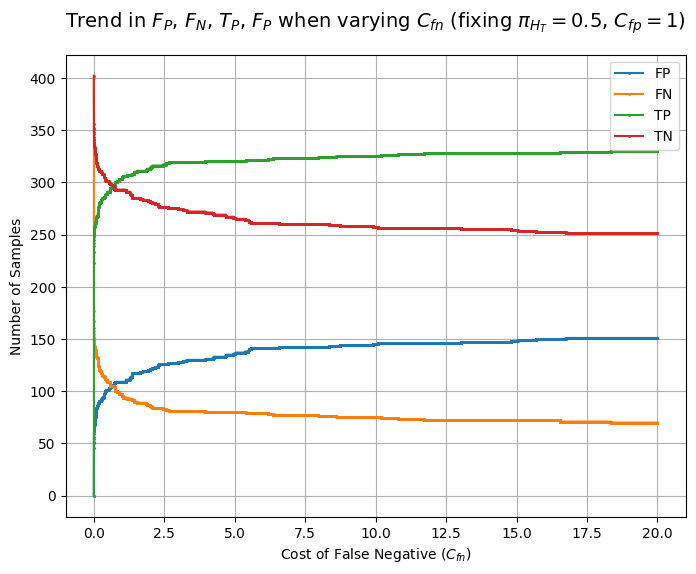

In [21]:
#Chart for the relationship between FP, FN and Cfn error

CfnSpace = np.linspace(0, 20, 20000)

n_FP = []
n_FN = []
n_TP = []
n_TN = []

for i, Cfn_ in enumerate(CfnSpace):
    confM, _ = optimalBayesDecisionClassifier(llr_infPar, labels_infPar, 0.5, Cfn_, 1)
    #extract FP and FN from the confusion matrix
    n_FP.append(confM[1, 0]) #FP
    n_FN.append(confM[0, 1]) #FN
    n_TP.append(confM[1, 1]) #TP
    n_TN.append(confM[0, 0]) #TN


# Plot the results
#make two series one for FP and one for FN
plt.figure(figsize=(8, 6))
plt.plot(CfnSpace, n_FP, marker='o', linestyle='-', markersize=1, label='FP')
plt.plot(CfnSpace, n_FN, marker='o', linestyle='-', markersize=1, label='FN')
plt.plot(CfnSpace, n_TP, marker='o', linestyle='-', markersize=1, label='TP')
plt.plot(CfnSpace, n_TN, marker='o', linestyle='-', markersize=1, label='TN')
plt.title("Trend in $F_P$, $F_N$, $T_P$, $F_P$ when varying $C_{fn}$ (fixing $\pi_{H_T} = 0.5$, $C_{fp} = 1$)", pad=20, fontsize=14)
plt.xlabel("Cost of False Negative ($C_{fn}$)")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(True)
plt.show()

**Result: when $C_{fn}$, so the cost of assigning label $H_F$ to samples whose actual class is $H_T$, increases, the Classifier will make more false positive errors and less false negative errors.**

C:\Users\Utente\AppData\Local\Temp\ipykernel_8792\4091664869.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  t = -1 * np.log((PriorTrue * Cfn) / ((1 - PriorTrue) * Cfp))


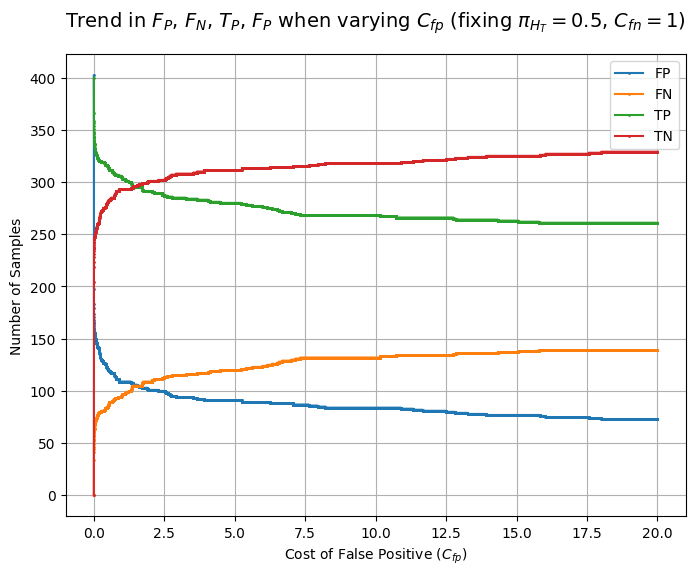

In [22]:
#Chart for the relationship between FP, FN and Cfp error

CfpSpace = np.linspace(0, 20, 20000)

n_FP = []
n_FN = []
n_TP = []
n_TN = []

for i, Cfp_ in enumerate(CfpSpace):
    confM, _ = optimalBayesDecisionClassifier(llr_infPar, labels_infPar, 0.5, 1, Cfp_)
    #extract FP and FN from the confusion matrix
    n_FP.append(confM[1, 0]) #FP
    n_FN.append(confM[0, 1]) #FN
    n_TP.append(confM[1, 1]) #TP
    n_TN.append(confM[0, 0]) #TN


# Plot the results
#make two series one for FP and one for FN
plt.figure(figsize=(8, 6))
plt.plot(CfnSpace, n_FP, marker='o', linestyle='-', markersize=1, label='FP')
plt.plot(CfnSpace, n_FN, marker='o', linestyle='-', markersize=1, label='FN')
plt.plot(CfnSpace, n_TP, marker='o', linestyle='-', markersize=1, label='TP')
plt.plot(CfnSpace, n_TN, marker='o', linestyle='-', markersize=1, label='TN')
plt.title("Trend in $F_P$, $F_N$, $T_P$, $F_P$ when varying $C_{fp}$ (fixing $\pi_{H_T} = 0.5$, $C_{fn} = 1$)", pad=20, fontsize=14)
plt.xlabel("Cost of False Positive ($C_{fp}$)")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(True)
plt.show()

**Result: when $C_{fp}$, so the cost of assigning label $H_T$ to samples whose actual class is $H_F$, increases, the Classifier will make more false negative errors and less false positive errors.**

## Binary task: evaluation
We now turn our attention at evaluating the predictions made by our classifier $\mathcal{R}$ for a target application with Prior and costs given by the triplet $(\pi_1, C_{fn}, C_{fp})$. <br>
At evaluation time,  $\mathcal{R}$ performs decisions for the test samples and finds the optimal ones according to the Posteriors (which are its believes). WE want to know what is the cost when using the system over data having their own labels. As we have seen,
we can compute the **empirical Bayes risk** (or **detection cost function**, *DCF*), that represents the cost that
we pay due to our decisions $c^* = argmin_c \{ C_{X, \mathcal{R}}(c) \}$
for the test data. The risk can be expressed as:
$$
\mathcal{B} = \mathop{\mathbb{E}}_{X, C \mid \mathcal{E}} \left[ C^* (x, \mathcal{R} \mid c)\right]
$$
Beware that this can also be written as: $\mathcal{B} = \mathop{\mathbb{E}}_{X, C \mid \mathcal{E}} \left[ C^* (a^*(x, \mathcal{R}) \mid c)\right]$ since $C^*$ is the cost for taking the **optimal** decision $a^*$. However, to simplify the notation, we will usually use the first representation.<br>
In the formula, $\mathcal{E}$ denotes the evaluation population, assumed to be distributed according
to $X, C \mid \mathcal{E}$. $\mathcal{E}$ is basically an evaluator who knows the complete distribution of
data. <br>
So, $\mathcal{B}$ is nothing else than the expected cost for our evaluation samples, computer over optimal costs of optimal decisions $a^* (x, \mathcal{R})$. <br>
Since $\mathcal{E}$ knows the complete distribution of the data, we can say that the evaluation population is sampled from $f_{X, C \mid \mathcal{E}} (x, c)$, which is the distribution of all the $(x_t, c_t)$ (which are the oberved samples with their observed labels). <br>
So, when we apply the Classifier $\mathcal{R}$ over these samples from the distribution above, we want to know the cost to pay. For each pair $(X, C)$ we can take the optimal cost for the optimal decision, $C^* (x, \mathcal{R} \mid c)$, weighted by the distribution density $f_{X, C \mid \mathcal{E}} (x, c)$:
$$
\mathcal{B} = \mathop{\mathbb{E}}_{X, C \mid \mathcal{E}} \left[ C^* (x, \mathcal{R} \mid c)\right] = \int \int C^*(x, \mathcal{R} \mid c) f_{X, C \mid \mathcal{E}}(x, c) \, dx \, dc
$$
Since in our case the classes are discrete, instead of an integral over $dc$ we can insert a sum:
$$
\mathcal{B} = \mathop{\mathbb{E}}_{X, C \mid \mathcal{E}} \left[ C^* (x, \mathcal{R} \mid c)\right] = \sum_{c = 0}^{K-1}  \int C^*(x, \mathcal{R} \mid c) f_{X, C \mid \mathcal{E}}(x, c) \, dx
$$
If $\mathcal{R}$ is a Generative Model, like in our case, we can factorize the Joint into the conditional and the Prior: 
$$
\mathcal{B} = \mathop{\mathbb{E}}_{X, C \mid \mathcal{E}} \left[ C^* (x, \mathcal{R} \mid c)\right] = \sum_{c = 0}^{K-1}  \int C^*(x, \mathcal{R} \mid c) f_{X \mid C, \mathcal{E}}(x \mid c) P(C = c) \, dx \\
= \sum_{c = 0}^{K-1}  \int C^*(x, \mathcal{R} \mid c) f_{X \mid C, \mathcal{E}}(x \mid c) \pi_c \, dx
$$
Since the Prior $\pi_c$ does not depend on the test sample $x$ (which is the integration variable), we can put it outside the integral. The final formula for the expected Bayes Risk is thus:
$$
\mathcal{B} = \mathop{\mathbb{E}}_{X, C \mid \mathcal{E}} \left[ C^* (x, \mathcal{R} \mid c)\right] = \sum_{c = 0}^{K-1}  \pi_c \int C^*(x, \mathcal{R} \mid c) f_{X \mid C, \mathcal{E}}(x \mid c) \, dx
$$
This whole formula encodes that, for each class $c$, we have to first compute the cost of optimal decision for sample $x$ using the Recongizer $\mathcal{R}$, given that $x \in c$, then we have to multiply this cost with the conditional and integrate over all the samples to find the expectation wrt the samples of class $c$, then we have to sum this value over all the classes. <br>
Note that the distribution $X \mid C, \mathcal{E}$ reflects the knowledge of the evaluator $\mathcal{E}$, not
the knowledge of the Recognizer $\mathcal{R}$. <br> <br>
The problem now is that we **do not know** $f_{X \mid C, \mathcal{E}}(x \mid c)$ (which is the conditional density according to evaluator $\mathcal{E}$, so the data distribution according to $\mathcal{E}$). However, we have at our disposal a **labeled dataset**: $(x_0, c_0), ..., (x_N, c_{K-1})$. It's important to stress the fact that **we know the actual labels** of this data. We assume that these samples are drawn from the distribution $X \mid C, \mathcal{E}$, according to $f_{X \mid C, \mathcal{E}}(x \mid c)$. This means that,  if the number of samples per class
becomes large, we can approximate the integral of the expectation by
averaging the cost over the samples of each class. This is called **empirical Expectation**:
$$
\int C^*(x, \mathcal{R} | c) f_{X|C, \mathcal{E}}(x | c) dx \approx \frac{1}{N_c} \sum_{i | c_i = c} C^*(x_i, \mathcal{R} | c)
$$
where $N_c$ is the number of classes. <br>
If we compute this for each class and multiply it by the Prior of each class and them sum all together, we can finally compute the **Empirical Bayes Risk**:
$$
\mathcal{B}_{\text{emp}} = \sum_{c=0}^{K-1} \frac{\pi_c}{N_c} \sum_{i | c_i = c} C^*(x_i, \mathcal{R} | c) = \sum_{c=0}^{K-1} \frac{\pi_c}{N_c} \sum_{i | c_i = c} C^*(c_{i}^* | c)
$$
and we can say that $\mathcal{B} \approx \mathcal{B}_{\text{emp}}$. <br>
In the second formula, $c_i$
is the actual class for sample $x_i$ and $c_{i}^*$
is the predicted class (by $\mathcal{R}$) for the same sample. <br>
For a binary problem, $\mathcal{B}_{\text{emp}}$ can also be expressed as:
$$
\mathcal{B}_{\text{emp}} = \pi_T C_{fn} P_{fn} + (1 - \pi_T) C_{fp} P_{fp}
$$
where $P_{fn}$ and $P_{fp}$
are the false negative and false positive rates (also called $\text{FNR}$, $\text{FPR}$). These can be computed from the confusion matrix $\mathbf{M}$.
Remember that $M_{i,j}$ represents the number of samples of class $j$ predicted as belonging to class $i$. We
can then compute: 
$$
P_{fn} = \frac{FN}{FN + TP} = \frac{M_{0,1}}{M_{0,1} + M_{1,1}}, \quad P_{fp} = \frac{FP}{FP + TN} = \frac{M_{1,0}}{M_{0,0} + M_{1,0}}
$$





So, let's write a function that computes the Bayes risk from the confusion matrix corresponding to the optimal
decisions for an application $(\pi_T, C_{fp}, C_{fn})$:

In [23]:
def computeEmpiricalBayesRisk(llrs, LVAL, PriorTrue, Cfn, Cfp):
    """
    Compute the empirical Bayes risk for a given prior and cost function.
    Args:
    - llrs: log likelihood ratios
    - LVAL: actual labels
    - PriorTrue: Prior probability of the true class
    - Cfn: Cost of false negative
    - Cfp: Cost of false positive
    Returns:
    - Empirical Bayes risk
    """

    confMatrix, _ = optimalBayesDecisionClassifier(llrs, LVAL, PriorTrue, Cfn, Cfp)
    #now, extract the TP, TN, FP and FN from the confusion matrix
    TP = confMatrix[1, 1] #True Positives
    TN = confMatrix[0, 0] #True Negatives
    FP = confMatrix[1, 0] #False Positives
    FN = confMatrix[0, 1] #False Negatives

    #comupte Pfn, Pfp
    Pfn = FN / (FN + TP) #False Negative Rate
    Pfp = FP / (FP + TN) #False Positive Rate

    return (PriorTrue * Cfn * Pfn) + ((1 - PriorTrue) * Cfp * Pfp) #Empirical Bayes Risk
    
    

In [24]:
#Test the empirical Bayes risk with four different sets of params

PriorsSet = [0.5, 0.8, 0.5, 0.8]
CfnSet = [1, 1, 10, 1]
CfpSet = [1, 1, 1, 10]

for testIndex in range(len(PriorsSet)):
    risk = computeEmpiricalBayesRisk(llr_infPar, labels_infPar, PriorsSet[testIndex], CfnSet[testIndex], CfpSet[testIndex])
    print(f"\nEmpirical Bayes Risk, Commedia infPar Binary Classifier, Test {testIndex}: {risk :.3f}")


Empirical Bayes Risk, Commedia infPar Binary Classifier, Test 0: 0.256

Empirical Bayes Risk, Commedia infPar Binary Classifier, Test 1: 0.225

Empirical Bayes Risk, Commedia infPar Binary Classifier, Test 2: 1.118

Empirical Bayes Risk, Commedia infPar Binary Classifier, Test 3: 0.724


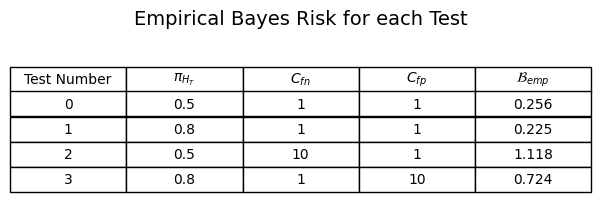

In [25]:
#table of empirical Bayes risk for each test

rows = [
    ["Test Number", "$\pi_{H_T}$", "$C_{fn}$", "$C_{fp}$", "$\mathcal{B}_{emp}$"],
    [0, 0.5, 1, 1, round(computeEmpiricalBayesRisk(llr_infPar, labels_infPar, 0.5, 1, 1), 3)],
    [1, 0.8, 1, 1, round(computeEmpiricalBayesRisk(llr_infPar, labels_infPar, 0.8, 1, 1), 3)],
    [2, 0.5, 10, 1, round(computeEmpiricalBayesRisk(llr_infPar, labels_infPar, 0.5, 10, 1), 3)],
    [3, 0.8, 1, 10, round(computeEmpiricalBayesRisk(llr_infPar, labels_infPar, 0.8, 1, 10), 3)],
]

fig, ax = plt.subplots(figsize=(5, 2))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=rows, colLabels=None, cellLoc='center', loc='center')
plt.title("Empirical Bayes Risk for each Test", pad=20, fontsize=14)
table.auto_set_font_size(False)  # Disable auto font size
table.set_fontsize(10)  # Set a fixed font size
table.scale(1.5, 1.5)  # Adjust the scale for better visibility
plt.show()

$\mathcal{B}_{\text{emp}}$ is also called (**un-normalized**) *Detection Cost Function* (DCF). We say
*un-normalized* because this value doesn’t tell a lot by itself. <br>
We can compute
a **normalized Detection Cost Function**, by dividing the Bayes risk by the risk of an optimal system that does not
use the test data at all and only relies on Priors. <br>
If we consider a dummy system that always classifies a test sample as $H_T$, we would have $P_{fp} = 1$, $P_{fn} = 0$ that imply $DCF_u = (1 - \pi_T)C_{fp}$. <br>
Similarly, a dummy system that always classifies a test sample as $H_F$ we would have $P_{fp} = 0$, $P_{fn} = 1$ that imply $DCF_u = \pi_T C_{fn}$. <br>
We compare the system DCF w.r.t. the best dummy system to get the normalized DCF:

$$
\mathcal{B}_{\text{emp , norm. }} = DCF(\pi_T, C_{fn}, C_{fp}) = \frac{DCF_u(\pi_T, C_{fn}, C_{fp})}{\min(\pi_T C_{fn}, (1 - \pi_T)C_{fp})}
$$

Note that the best dummy system corresponds to optimal Bayes decisions based on Prior information alone. <br>
So, let's write the function to normalize te DCFs:


In [26]:
def computeEmpiricalBayesRisk_Normalized(llrs, LVAL, PriorTrue, Cfn, Cfp):
    """
    Compute the empirical Bayes risk for a given prior and cost function.
    Args:
    - llrs: log likelihood ratios
    - LVAL: actual labels
    - PriorTrue: Prior probability of the true class
    - Cfn: Cost of false negative
    - Cfp: Cost of false positive
    Returns:
    - Normalized Empirical Bayes risk
    """

    confMatrix, _ = optimalBayesDecisionClassifier(llrs, LVAL, PriorTrue, Cfn, Cfp)
    #now, extract the TP, TN, FP and FN from the confusion matrix
    TP = confMatrix[1, 1] #True Positives
    TN = confMatrix[0, 0] #True Negatives
    FP = confMatrix[1, 0] #False Positives
    FN = confMatrix[0, 1] #False Negatives

    #comupte Pfn, Pfp
    Pfn = FN / (FN + TP) #False Negative Rate
    Pfp = FP / (FP + TN) #False Positive Rate

    Bemp = (PriorTrue * Cfn * Pfn) + ((1 - PriorTrue) * Cfp * Pfp) #Empirical Bayes Risk


    #Now calculate the Bemp for the two dummy systems:
    Bemp_dummy1= PriorTrue * Cfn
    Bemp_dummy2 = (1 - PriorTrue) * Cfp
    #take the min between the two Bemp dummy
    Bemp_dummy = min(Bemp_dummy1, Bemp_dummy2)

    return Bemp / Bemp_dummy #Normalized Empirical Bayes Risk

    

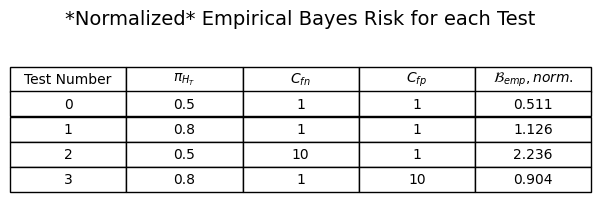

In [27]:
rows = [
    ["Test Number", "$\pi_{H_T}$", "$C_{fn}$", "$C_{fp}$", "$\mathcal{B}_{emp}, norm.$"],
    [0, 0.5, 1, 1, round(computeEmpiricalBayesRisk_Normalized(llr_infPar, labels_infPar, 0.5, 1, 1), 3)],
    [1, 0.8, 1, 1, round(computeEmpiricalBayesRisk_Normalized(llr_infPar, labels_infPar, 0.8, 1, 1), 3)],
    [2, 0.5, 10, 1, round(computeEmpiricalBayesRisk_Normalized(llr_infPar, labels_infPar, 0.5, 10, 1), 3)],
    [3, 0.8, 1, 10, round(computeEmpiricalBayesRisk_Normalized(llr_infPar, labels_infPar, 0.8, 1, 10), 3)],
]

fig, ax = plt.subplots(figsize=(5, 2))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=rows, colLabels=None, cellLoc='center', loc='center')
plt.title("*Normalized* Empirical Bayes Risk for each Test", pad=20, fontsize=14)
table.auto_set_font_size(False)  # Disable auto font size
table.set_fontsize(10)  # Set a fixed font size
table.scale(1.5, 1.5)  # Adjust the scale for better visibility
plt.show()

Based on what we obtain, we can actually say if our system is *good / useful* or *harmful /useless*:
- if $DCF(\pi_T, C_{fn}, C_{fp}) > 1 \Rightarrow$ our system is **harmful**
- if $DCF(\pi_T, C_{fn}, C_{fp}) \lt 1 \Rightarrow$ our system is **good**

**We can observe that only in two cases the DCF is lower than 1, in the remaining cases our system is actually harmful.**


## Minimum detection costs

We have seen during the lectures that, for binary tasks, we can measure the contribution to the cost due
to poor class separation and the contribution due to poor score calibration: our classifier does not produce outputs that represent log-likelihood ratios, thus the theoretical threshold is not optimal anymore
(note that this happens even for generative models — for example, the model parameters may not be
consistent between training and test population). <br>
**Scores can be re-calibrated** by using a (small) set of labeled samples, that behave similarly to the evaluation population and were not used for model training (i.e. a validation set). Alternatively, we can
compute the optimal threshold for a given application on the same validation set, and use such threshold
for the test population (K-fold cross validation can be also exploited to extract validation sets from the
training data when validation data is not available). <br>
Even if we do not have available such data, it may still be interesting knowing how good the model would
perform if we had selected the best possible threshold. **To this extent, we can compute the (normalized) DCF over the test set using all possible thresholds, and select its minimum value.** <br>
In practice, we have to make these considerations:
- The $DCF(\pi_T, C_{fn}, C_{fp})$ (or, it's the same, the $\mathcal{B}_{\text{emp, norm}}$) measures how well our system makes decisions. These decisions are determined by **comparing a score to a threshold.** In our case the scores are the log-likelihoods ratios and the threshold is computed from the application triplet of type $(\pi_{H_T}, C_{fn}, C_{fp})$.
-  If we shift the threshold **without** crossing a score, the classification of any given sample doesn't change. For example, imagine we have scores $[1, 2, 3]$ and our threshold is $t = 1.5$. Samples with scores $2$ and $3$ are classified as one class, and the sample with score $1$ as the other. If we change the threshold to $t = 1.7$, the classifications remain the same. Therefore, the confusion matrix, and consequently the DCF, also remain the same.
- So, the DCF is **piecewise constant** (it's like a *step function*, more precisely it's a monotonic increasing step function): **it only changes at the score values** because the only time the classification of a sample changes is when the threshold moves past its score.

Therefore, to compute all the possible values for the DCF and select the *minimum*, we only need to check the DCF at the points where it can change.  And those points are precisely the **test scores**. <br>
So, more precisely, we consider a set that contains all the possible test scores, sorted in an **increasing order**, plus the limit values of $\infty$ and $- \infty$ to represent the extreme cases of rejecting all samples and accepting all samples: 
$$
\left( - \infty, s_0, s_1, s_2, ..., s_M, \infty \right)
$$
We consider all the elements in this set as thresholds $(t_0, t_1, ..., t_N)$ , and for each threshold $t$ we compute  the confusion matrix on the test set itself that would be obtained
if scores were thresholded at $t$, and the corresponding normalized DCF using the code developed in the previous section. Remember that in our case the **scores are the $\text{llr}(x)$, that we have to sort in increasing order:

In [28]:
llr_infPar.shape    #This are llr gonna be used as THRESHOLDS

(802,)

In [29]:
def computeMinEmpiricalBayesRisk_Normalized(scores, LVAL, PriorTrue, Cfn, Cfp):
    """
    Compute the minimum Bayes normalized empirical risk (= the min DCF) for a given prior and cost function.
    Args:
    - scores: log likelihood ratios
    - LVAL: actual labels
    - PriorTrue: Prior probability of the true class
    - Cfn: Cost of false negative
    - Cfp: Cost of false positive
    Returns:
    - Minimum Bayes normalized empirical risk
    """


    #1. sort the scores in increasing order to use them as thresholds
    sortedScores = np.sort(scores)

    #2. add the -inf and +inf to the sorted scores to use them as thresholds
    sortedScores = np.concatenate(([-np.inf], sortedScores, [np.inf])) 
    #now we have sortedScores = (-inf, s0, s1, s2, ..., sN, +inf)

    #3. for each threshold, compute the empirical Bayes risk
    DCFList = [] #initialize the DCFList with an empty list

    for t in sortedScores:
        #score IS THE THRESHOLD!
        #Classification rule: if llr > t, classify as 1, else classify as 0
        PVAL = np.where(scores > t, 1, 0)

        #compute confusion matrix
        confMatrix = computeConfMatrix(PVAL, LVAL)


        #now, extract the TP, TN, FP and FN from the confusion matrix
        TP = confMatrix[1, 1] #True Positives
        TN = confMatrix[0, 0] #True Negatives
        FP = confMatrix[1, 0] #False Positives
        FN = confMatrix[0, 1] #False Negatives

        #comupte Pfn, Pfp
        Pfn = FN / (FN + TP) #False Negative Rate
        Pfp = FP / (FP + TN) #False Positive Rate

        Bemp = (PriorTrue * Cfn * Pfn) + ((1 - PriorTrue) * Cfp * Pfp) #Empirical Bayes Risk


        #Now calculate the Bemp for the two dummy systems:
        Bemp_dummy1= PriorTrue * Cfn
        Bemp_dummy2 = (1 - PriorTrue) * Cfp
        #take the min between the two Bemp dummy
        Bemp_dummy = min(Bemp_dummy1, Bemp_dummy2)

        DCF_i = Bemp / Bemp_dummy #Normalized Empirical Bayes Risk

        DCFList.append(DCF_i) #append the DCF_i to the DCFList


    #4. find the minimum DCF in the DCFArray
    return min(DCFList) 
    

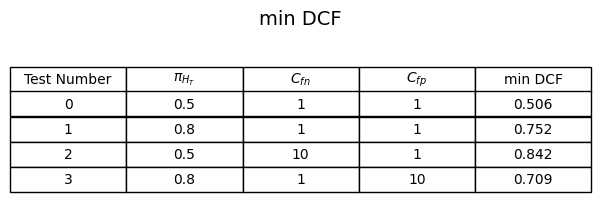

In [30]:
rows = [
    ["Test Number", "$\pi_{H_T}$", "$C_{fn}$", "$C_{fp}$", "min DCF"],
    [0, 0.5, 1, 1, round(computeMinEmpiricalBayesRisk_Normalized(llr_infPar, labels_infPar,0.5, 1, 1 ), 3)],
    [1, 0.8, 1, 1, round(computeMinEmpiricalBayesRisk_Normalized(llr_infPar, labels_infPar, 0.8, 1, 1), 3)],
    [2, 0.5, 10, 1, round(computeMinEmpiricalBayesRisk_Normalized(llr_infPar, labels_infPar, 0.5, 10, 1), 3)],
    [3, 0.8, 1, 10, round(computeMinEmpiricalBayesRisk_Normalized(llr_infPar, labels_infPar, 0.8, 1, 10), 3)],
]

fig, ax = plt.subplots(figsize=(5, 2))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=rows, colLabels=None, cellLoc='center', loc='center')
plt.title("min DCF", pad=20, fontsize=14)
table.auto_set_font_size(False)  # Disable auto font size
table.set_fontsize(10)  # Set a fixed font size
table.scale(1.5, 1.5)  # Adjust the scale for better visibility
plt.show()

The values right here are the normnalized Bayes Empirical Risks that we would have with a **perfect score calibration**. They are all $\lt 1$ so the four test systems are **all good and useful**. <br>
However, comparing this scores to the DCF we computed before, with the except of the first application, we can observe a significant loss due to poor calibration. This
loss is even more significant for the two applications which had a normalized DCF larger than 1. In these
two scenarios, our classifier is able to provide discriminant scores, but **we were not able to employ the scores to make better decisions than those that we would make from the Prior alone** (so, using the *dummy system* that just looks at $\pi_{H_T}$).


## ROC curves
ROC (*Receiver Operating Characteristic*) curves are a method to evaluate the trade-off between the different kind of errors for our Recognizer $\mathcal{R}$. ROC curves can be used, for example, to plot false positive rates $ \left( \text{FPR} = P_{fp} \right)$ versus true positive rates $ \left( \text{TPR} = P_{tp} \right)$ as the
threshold $t$ varies. Note that these plots do not account for errors due to poor selection of the threshold
(i.e. mis-calibration), since they simply plot how the error rates change when we modify the threshold
on the evaluation set. <br>
Here we're gonna plot the ROC which confronts $P_{fp}$ with $P_{tp}$ for the 2-class problem scores (array of $\text{llr}(x)$):

In [31]:
def plotROC_FPRvsTPR(scores, LVAL):
    """
    Plot the ROC curve for a given set of scores and labels.
    Args:
    - scores: log likelihood ratios
    - LVAL: actual labels
    """


    #1. sort the scores in increasing order to use them as thresholds
    sortedScores = np.sort(scores)

    #2. add the -inf and +inf to the sorted scores to use them as thresholds
    sortedScores = np.concatenate(([-np.inf], sortedScores, [np.inf])) 
    #now we have sortedScores = (-inf, s0, s1, s2, ..., sN, +inf)

    #initialize the x and y axis for the ROC curve
    xAxis = [] 
    yAxis = [] 

    for t in sortedScores:
        #score IS THE THRESHOLD!
        #Classification rule: if llr > t, classify as 1, else classify as 0
        PVAL = np.where(scores > t, 1, 0)

        #compute confusion matrix
        confMatrix = computeConfMatrix(PVAL, LVAL)


        #now, extract the TP, TN, FP and FN from the confusion matrix
        TP = confMatrix[1, 1] #True Positives
        TN = confMatrix[0, 0] #True Negatives
        FP = confMatrix[1, 0] #False Positives
        FN = confMatrix[0, 1] #False Negatives

        #comupte Pfn, Pfp
        Pfn = FN / (FN + TP) #False Negative Rate
        Pfp = FP / (FP + TN) #False Positive Rate
        Ptp = 1 - Pfn #True Positive Rate

        #ROC: Pfp vs Ptp
        #Pfp on x axis, Ptp on y axis
        xAxis.append(Pfp)
        yAxis.append(Ptp)

    #3. plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(xAxis, yAxis, marker='o', linestyle='-', markersize=1, color='blue')
    plt.title("ROC Curve: FPR vs TPR", pad=20, fontsize=14)
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.grid(True)
    #limit the x and y axis to [0, 1], since the values of FPR and TPR are between 0 and 1
    #this is done for better visualization of the ROC curve, not to have empty parts of the plot
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()


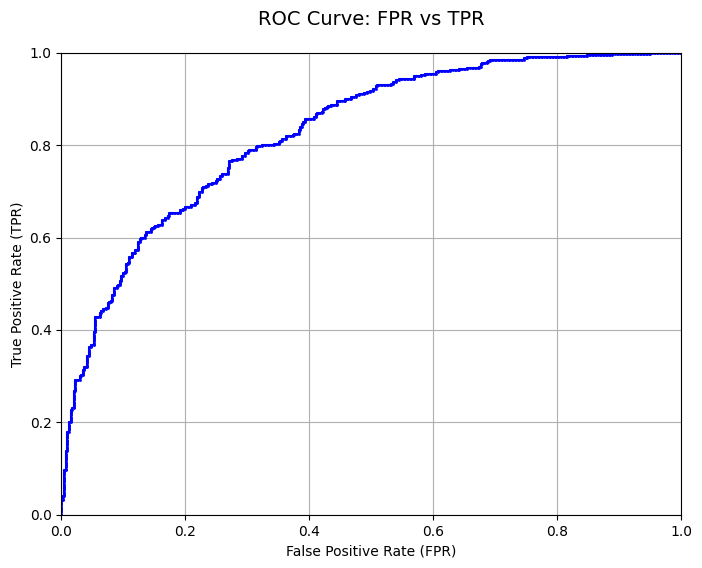

In [32]:
plotROC_FPRvsTPR(llr_infPar, labels_infPar)

## Bayes error plots
The last tool that we consider to assess the performance of our recognizer $\mathcal{R}$ consists in plotting the normalized costs as a function of an **effective Prior** $\tilde{\pi}$. <br>
For binary problems, an application defined by the triplet $(\pi_{H_T}, C_{fn}, C_{fp})$ is actually **equivalent** to a *general* application $(\tilde{\pi}, 1, 1)$ where the costs are normalized and have both unitary value and the $\tilde{\pi}$ is the effective Prior, calculated as:
$$
\tilde{\pi} = \frac{\pi_T C_{fn}}{\pi_T C_{fn} + (1 - \pi_T) C_{fp}}
$$
In order to demonstrate this we have to recall the classification rule we use with the binary Classifier, which compares the $\text{llr}(x)$ with a Threshold $t$:

$$
c^* =
\begin{cases}
    H_T & \text{if } \text{llr}(x) = \log \frac{f_{X|C,\mathcal{R}}(x|H_T)}{f_{X|C,\mathcal{R}}(x|H_F)} > t = - \log \frac{\pi_{H_T} C_{fn}}{(1- \pi_{H_T}) C_{fp}} \\ \\
    H_F & \text{if } \text{llr}(x) = \log \frac{f_{X|C,\mathcal{R}}(x|H_T)}{f_{X|C,\mathcal{R}}(x|H_F)} \le t = - \log \frac{\pi_{H_T} C_{fn}}{(1- \pi_{H_T}) C_{fp}}
\end{cases}
$$

The threshold $t$ can be rewritten as:
$$
t = \log \frac{(1- \pi_{H_T}) C_{fp}}{\pi_{H_T} C_{fn}}
$$

Now, let's consider the normalized cost scenario where the costs of false negative and false positive are both 1 ($C'_{fn} = 1$ and $C'_{fp} = 1$) and the effective Prior for the true class is $\tilde{\pi}$. The classification rule in this normalized scenario would have a threshold $\tilde{t}$:

$$
\tilde{t} = - \log \frac{\pi_{H_T} C'_{fn}}{(1- \pi_{H_T}) C'_{fp}} \bigg|_{C'_{fn} = C'_{fp} = 1} = - \log \frac{\tilde{\pi} \cdot 1}{(1 - \tilde{\pi}) \cdot 1} = - \log \frac{\tilde{\pi}}{1 - \tilde{\pi}} = \log \frac{1 - \tilde{\pi}}{\tilde{\pi}}
$$


**The fundamental idea behind the effective Prior is that the decision boundary (the threshold) should correspond to the same operating point in both the original and the normalized cost scenarios. Since in the normalized scenario we have unitary costs, the effective Prior will take into account the original costs ($C_{fn}$ and $C_{fp}$) in order to make the two applications equivalent.** Therefore, we can equate the thresholds:

$$t = \tilde{t}$$

$$
\log \left( \frac{(1- \pi_{H_T}) C_{fp}}{\pi_{H_T} C_{fn}} \right) = \log \left( \frac{1 - \tilde{\pi}}{\tilde{\pi}} \right)
$$

We can then exponentiate both terms:

$$
\frac{(1- \pi_{H_T}) C_{fp}}{\pi_{H_T} C_{fn}} = \frac{1 - \tilde{\pi}}{\tilde{\pi}}
$$

Now, we solve this equation for $\tilde{\pi}$:

$$
(1 - \tilde{\pi}) \pi_{H_T} C_{fn} = \tilde{\pi} (1 - \pi_{H_T}) C_{fp}
$$

$$
\pi_{H_T} C_{fn} - \tilde{\pi} \pi_{H_T} C_{fn} = \tilde{\pi} (1 - \pi_{H_T}) C_{fp}
$$

$$
\pi_{H_T} C_{fn} = \tilde{\pi} (1 - \pi_{H_T}) C_{fp} + \tilde{\pi} \pi_{H_T} C_{fn}
$$

$$
\pi_{H_T} C_{fn} = \tilde{\pi} [ (1 - \pi_{H_T}) C_{fp} + \pi_{H_T} C_{fn} ]
$$

Finally, we isolate the effective Prior $\tilde{\pi}$:

$$
\tilde{\pi} = \frac{\pi_{H_T} C_{fn}}{(1 - \pi_{H_T}) C_{fp} + \pi_{H_T} C_{fn}}
$$

This demonstrates how the formula for the effective Prior arises from equating the decision thresholds of the original cost scenario and the normalized cost scenario. <br> <br>
So, The normalized Bayes Error Plot allows assessing the performance of the Recognizer $\mathcal{R}$ as **we vary the application**, i.e. as a function of prior log-odds:
$$
\tilde{p} = \log \frac{1 - \tilde{\pi}}{\tilde{\pi}}
$$
In order to compute the Bayes Error Plot, we can consider values of $\tilde{p}$ ranging, for example, from $-3$ to $+3$. Then, for each value of $\tilde{p}$, we compute $\tilde{\pi}$:
$$
\tilde{p} = \log \frac{1 - \tilde{\pi}}{\tilde{\pi}} \Longleftrightarrow e^{\tilde{p}} (1- \tilde{\pi}) = \tilde{\pi} \Longleftrightarrow \tilde{\pi} = \frac{e^{\tilde{p}}}{1 + e^{\tilde{p}}} \Longleftrightarrow \tilde{\pi} = \frac{1}{1 + e^{- \tilde{p}}}
$$
After that, we compute the normalized DCF, and the normalized minimum DCF corresponding to $\tilde{\pi}$ and then plot these values as a function of $\tilde{p} = \log \frac{1 - \tilde{\pi}}{\tilde{\pi}}$: 

In [33]:
def plotBayesErrorPlots(effPriorLogOdds, scores, LVAL):
    """
    Plot the Bayes error plots for a given range of log odds ratios and scores.
    Args:
    - logOddsRange: range of log odds ratios -> used to compute the effective Prior
    - scores: log likelihood ratios
    - LVAL: actual labels
    """

    #effPriorLogOdds will be the x axis of the plot
    xAxis = effPriorLogOdds
    #the plot will have two series: one for the DCF and the other for the min DCF -> they will be on the y axis
    #(ofc the are *normalized*)
    series0_yAxis = [] #y axis for the DCF
    series1_yAxis = [] #y axis for the min DCF

    #Cfp = 1, Cfn = 1

    #computeEmpiricalBayesRisk_Normalized(llrs, LVAL, PriorTrue, Cfn, Cfp):

    for tildeP in effPriorLogOdds:

        #compute the effective Prior from tildeP
        effectivePrior = 1 / (1 + np.exp(-tildeP))

        # compute DCF
        DCF = computeEmpiricalBayesRisk_Normalized(scores, LVAL, effectivePrior, 1, 1)
        series0_yAxis.append(DCF)
        # compute min DCF
        minDCF = computeMinEmpiricalBayesRisk_Normalized(scores, LVAL, effectivePrior, 1, 1)
        series1_yAxis.append(minDCF)

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(xAxis, series0_yAxis, marker='o', linestyle='-', markersize=1, label='DCF', color='red')
    plt.plot(xAxis, series1_yAxis, marker='o', linestyle='-', markersize=1, label='min DCF', color='blue')
    plt.title("Bayes Error Plots: DCF and min DCF vs Effective Prior Log Odds", pad=20, fontsize=14)
    plt.xlabel("Effective Prior Log Odds")
    plt.ylim([0, 1.1])
    plt.xlim([min(xAxis), max(xAxis)]) #set the x axis limits to the min and max of the x axis which are the effectivePriorLogOdds
    plt.grid(True)
    plt.legend()

    # Customize x-axis ticks
    num_ticks = 31  # Number of ticks to display on the x-axis 
    # Generate evenly spaced ticks, rotate them by 45 degrees and align them to the right to make them more clear
    plt.xticks(np.linspace(min(xAxis), max(xAxis), num_ticks), rotation=45, ha='right') 
    plt.show()

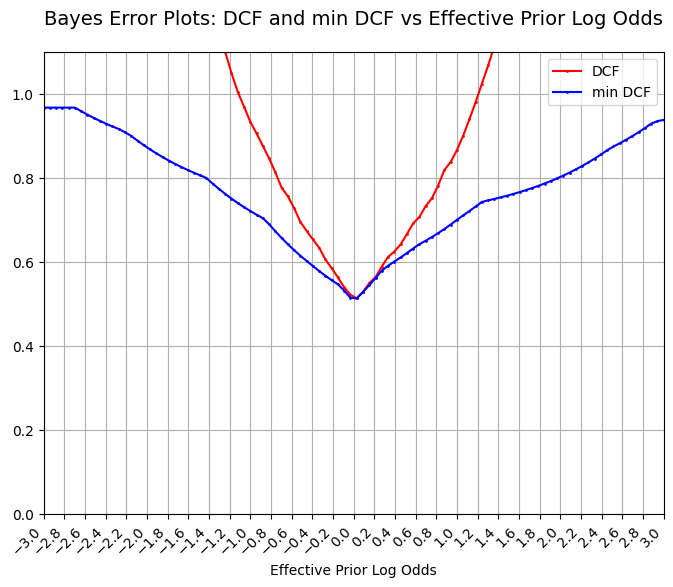

In [34]:
effPriorLogOdds = np.linspace(-3, 3, 100) #range of log odds ratios

plotBayesErrorPlots(effPriorLogOdds, llr_infPar, labels_infPar) #plot the Bayes error plots for the given range of log odds ratios and scores

- The application is a general, normalized application described by the triplet $(\tilde{\pi}, 1, 1)$. $\tilde{\pi}$ is computed from the Effective Priors log-odds $\tilde{p} = \log \frac{1 - \tilde{\pi}}{\tilde{\pi}}$. So $\tilde{\pi}$ is a function of $\tilde{p}$. This means the $\text{DCF}(\tilde{\pi}, 1, 1)$ and $\text{min DCF}(\tilde{\pi}, 1, 1)$ computed here are as well functions of $\tilde{p}$ and can be expressed as $\text{DCF}(\tilde{p}, 1, 1)$ and $\text{min DCF}(\tilde{p}, 1, 1)$. By changing $\tilde{p}$ we change the application and therefore we change $\text{DCF}(\tilde{p}, 1, 1)$ and $\text{min DCF}(\tilde{p}, 1, 1)$. The Bayes Error Plot wants to show these changes when varying $\tilde{p}$.
- The blue curve represents the $\text{min DCF}$ as a function of the Effective Prior log odds $\tilde{p}$ and represents the **best possible performance** the Recognizer $\mathcal{R}$ is able to deliver if we set an effective prior log-odds. It acts as a lower bound for the actual $\text{DCF}$. We can note, and this is quite expected (although for very harmful models it's not always the same), that the model is always **good/useful** for each value of $\tilde{p}$ because the $\text{min DCF}$ always remains below $1$, so the model is able to achieve better results than the best dummy system which just relies on the Effective Priors.
- The red curve represents the $\text{DCF}$ as a function of the Effective Prior log odds $\tilde{p}$ and shows the actual decision cost achieved by the Recognizer $\mathcal{R}$ at different operating points defined by the $\tilde{p}$ we choose. We can see that in this case, for values of $\tilde{p}$ approximately not belonging to the interval $(-1;1.4]$ the model becomes **harmful/useless** because $\text{DCF}(\tilde{p}, 1, 1) > 1$ so it cannot beat anymore the best of the dummy systems.
- The gap between the $\text{DCF}(\tilde{p}, 1, 1)$ and $\text{min DCF}(\tilde{p}, 1, 1)$ indicates the the **miss-calibration error** and indicates the room for improvement in the Classifier $\mathcal{R}$.
- The minimum of the $\text{min DCF}(\tilde{p}, 1, 1)$ curve (blue curve) suggests the **theoretically optimal operating point** for the recognizer $\mathcal{R}$. It corresponds to the working point $\tilde{p} = 0$, which in turn corresponds to this Effective Prior:
  $$
  \tilde{\pi}_{\tilde{p} = 0} = \tilde{\pi}_{\text{O.O.P.}} = \frac{e^{\tilde{p}}}{1 + e^{\tilde{p}}} \bigg|_{\tilde{p} = 0} = \frac{1}{1+1} = \frac{1}{2}
  $$
  $\tilde{\pi} = 0.5$ **indicates equal Prior probabilities for both classes in the effective normalized scenario** $\left(\tilde{\pi}_{H_T} = \tilde{\pi}_{H_F} = 0.5 \right)$.
- The shape of the $\text{DCF}$ curve tells us about the **robustness** of the system. A flatter curve indicates that the performance is less sensitive to changes in the operating conditions whereas a steeper curve tells us the Recognizer is much more sensitive to $\tilde{p}$. We can observe that the $\text{DCF}(\tilde{p}, 1, 1)$ is **much more sensitive** to the changes in the operating conditions than the $\text{min DCF}(\tilde{p}, 1, 1)$.

## Comparing Recognizers
We now employ the tools that we have seen to compare two different recognizers for the same 2-class
problem: correspond to the pseudocounts $\mathcal{E} = 0.001$
and $\mathcal{E} = 1$ variations of the Laboratory 7 multinomial model.

In [35]:
#Load llrs (scores) and labels for the second model having pseucocounts eps = 1
llr_infPar_eps1 = np.load("./data/commedia_llr_infpar_eps1.npy")
print(f"llr_infPar_eps1 shape: {llr_infPar_eps1.shape}")
labels_infPar_eps1 = np.load("./data/commedia_labels_infpar_eps1.npy")
print(f"labels_infPar_eps1 shape: {labels_infPar_eps1.shape}")

llr_infPar_eps1 shape: (802,)
labels_infPar_eps1 shape: (802,)


In [36]:
def plotBayesErrorPlotsMoreModels(models):
    """
    Plot the Bayes error plots for a given range of log odds ratios and scores.
    Args:
        - models: list of lists containing:
            - effPriorsLogOdds: range of log odds ratios -> used to compute the effective Prior
            - scores: log likelihood ratios
            - LVAL: actual labels
            - model_name: name of the model for the legend
    """

    plt.figure(figsize=(8, 6))

    for model in models:
        # unpack the parameters for the model
        effPriorLogOdds, scores, LVAL, model_name = model

        # set y axis for the specific model
        series0_yAxis = [] # y axis for the DCF
        series1_yAxis = [] # y axis for the min DCF

        # effPriorLogOdds will be the x axis of the plot
        xAxis = effPriorLogOdds

        for tildeP in effPriorLogOdds:
            # compute the effective Prior from tildeP
            effectivePrior = 1 / (1 + np.exp(-tildeP))
            #print(f"Effective Prior: {effectivePrior}")

            # compute DCF
            DCF = computeEmpiricalBayesRisk_Normalized(scores, LVAL, effectivePrior, 1, 1)
            series0_yAxis.append(DCF)

            # compute min DCF
            minDCF = computeMinEmpiricalBayesRisk_Normalized(scores, LVAL, effectivePrior, 1, 1)
            series1_yAxis.append(minDCF)

        # Plot the results for the current model
        plt.plot(xAxis, series0_yAxis, marker='o', linestyle='-', markersize=1, label=f'DCF ({model_name})')
        plt.plot(xAxis, series1_yAxis, marker='o', linestyle='-', markersize=1, label=f'min DCF ({model_name})')

    plt.title("Bayes Error Plots: DCF and min DCF vs Effective Prior Log Odds", pad=20, fontsize=14)
    plt.xlabel("Effective Prior Log Odds")
    plt.ylim([0, 1.1])
    plt.xlim([min(xAxis), max(xAxis)]) # set the x axis limits to the min and max of the x axis
    plt.grid(True)
    plt.legend()

    # Customize x-axis ticks
    num_ticks = 31 # Number of ticks to display on the x-axis
    # Generate evenly spaced ticks, rotate them by 45 degrees and align them to the right
    plt.xticks(np.linspace(min(xAxis), max(xAxis), num_ticks), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

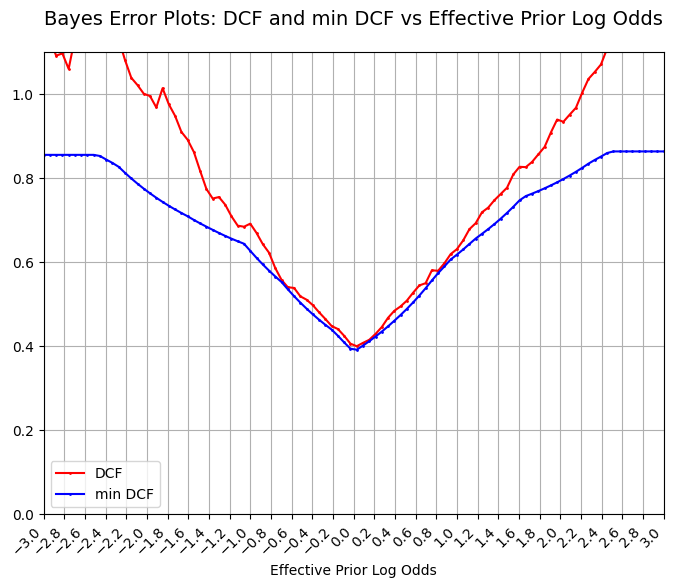

In [37]:
plotBayesErrorPlots(effPriorLogOdds, llr_infPar_eps1, labels_infPar_eps1)

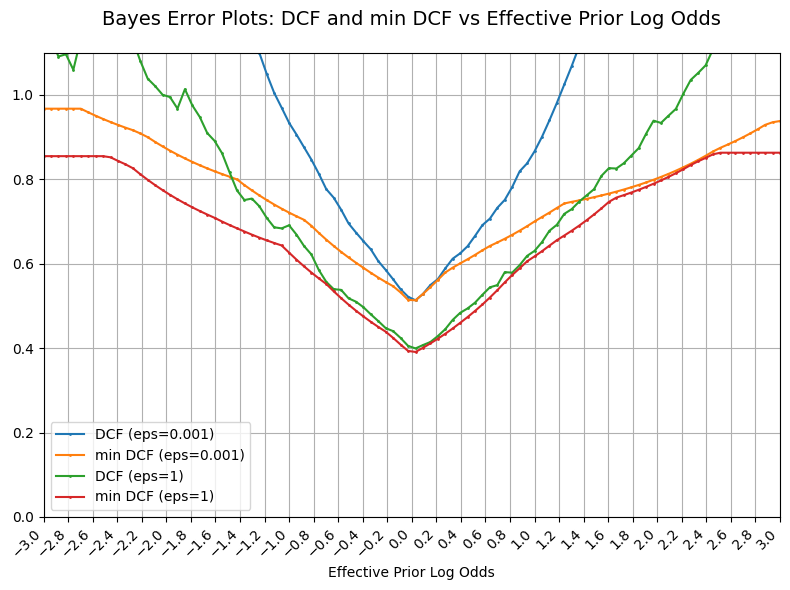

In [38]:
#Compare the two Recognizers

effPriorLogOdds = np.linspace(-3, 3, 100) #range of log odds ratios

models = [
    [effPriorLogOdds, llr_infPar, labels_infPar, "eps=0.001"],
    [effPriorLogOdds, llr_infPar_eps1, labels_infPar_eps1, "eps=1"]
]

plotBayesErrorPlotsMoreModels(models) #plot the Bayes error plots for the two models

We can conclude that the second model is superior over a wide range of applications (lower DCF), and
also produces better calibrated scores (lower gap between DCF and minimum DCF).


## Multiclass evaluation
We're moving into the realm of multiclass classification. The key difference between multiclass classification and binary classification is that the operating conditions are no longer governed by a single prior log-odds, and the decision rules involve comparing costs across multiple classes, so multiclass classification is generally **more complex**. As a matter of fact, in multiclass problem there are $K > 2$ distinct classes and instead of a single Prior probability $\pi_{H_T}$ determining the balance between all classes (as it was in the binary case), we now have a vector of Priors $\boldsymbol{\pi} = [\pi_0, \pi_1, \pi_2, ..., \pi_{K-1}]$ having $K$ Priors (one for each class) and satisying the probability contraint: $\sum_{k=0}^{K-1} \pi_k = 1$. Also the Cost matrix $\mathbf{C}$ is now more complex as it is now a $K \times K$ matrix, where $C_{i, j}$ is the cost of classifying a test sample actually belonging to class $j$ as class $i$. While the diagonal elements are typically zero because there's usually no cost in making the correct prediction ($C_{i,i}=0$), the off-diagonal elements $C_{i,j}$ where $i \neq j$
can have arbitrary relationships, introducing more independent parameters than in the binary case (where only $C_{fp}$ and $C_{fn}$ are independent after normalization). <br>
**The most important drawback here is that we cannot represent the whole application using a single paramater like the effective Prior $\tilde{\pi}$ used in the binary case**: the reduction to a single effective Prior in the binary case was possible because the decision was essentially one-dimensional (favoring one class over the other based on a single threshold). Multiclass problems introduce a higher-dimensional decision space governed by multiple Priors and a more complex cost structure, requiring the consideration of trade-offs between multiple classification possibilities. <br>
For these reasons, we restrict our analysis to confusion matrices and Bayes costs. <br>
In this case we have three classes, so the cost matrix has the
form:
$$
\mathbf{C} =
\begin{array}{c|ccc}
\text{ } & \text{Class 0} & \text{Class 1} & \text{Class 2} \\
\hline
\text{Predicted 0} & 0 & C_{0,1} & C_{0,2} \\
\text{Predicted 1} & C_{1,0} & 0 & C_{1,2} \\
\text{Predicted 2} & C_{2,0} & C_{2,1} & 0
\end{array}
= 
\begin{bmatrix}
0 & C_{0,1} & C_{0,2} \\
C_{1,0} & 0 & C_{1,2} \\
C_{2,0} & C_{2,1} & 0
\end{bmatrix}
$$
where $\text{Class 0} = C_0$ is *Inferno*, $\text{Class 1} = C_1$ is *Purgatorio* and $\text{Class 2} = C_2$ is *Paradiso*. <br>
The vector of Priors is this:
$$
\boldsymbol{\pi} =
\begin{bmatrix}
\pi_0 \\
\pi_1 \\
\pi_2
\end{bmatrix}
$$
where $\sum_{k=0}^{K-1} \pi_k = \pi_0 + \pi_1 + \pi_2 = 1$ (Rule of Probability). <br>
The Bayes cost of classifying a test sample $x_t$ as belonging to class $c$ can be computed as
$$
C_{x_t,\mathcal{R}}(c) = \sum_{k=0}^{K-1} C_{c,k}P(C = k|x_t, \mathcal{R})
$$

In [116]:
#load log-lieklihoods and labels for the 3 class problem
ll_commedia = np.load("./data/commedia_ll.npy")
labels_commedia = np.load("./data/commedia_labels.npy") 
print(f"ll_commedia shape: {ll_commedia.shape}")
print(f"labels_commedia shape: {labels_commedia.shape}")

ll_commedia shape: (3, 1204)
labels_commedia shape: (1204,)


In [117]:
#Prios vectors
PriorsVect = np.array([0.3, 0.4, 0.3])
print(f"PriorsVect shape: {PriorsVect.shape}") #check the shape of the Priors vector
print(f"PriorsVect:\n{PriorsVect}") #check the values of the Priors vector


#Cost Matrix
C = np.array([[0, 1, 2], [1, 0, 1], [2, 1, 0]])
print(f"\nCost Matrix shape: {C.shape}") #check the shape of the Cost Matrix
print(f"Cost Matrix:\n{C}") #check the values of the Cost Matrix

PriorsVect shape: (3,)
PriorsVect:
[0.3 0.4 0.3]

Cost Matrix shape: (3, 3)
Cost Matrix:
[[0 1 2]
 [1 0 1]
 [2 1 0]]


In [63]:
#Compute the matrix of the Posterior probabilities for the 3 class problem

#so first compute the joint from the lieklihoods and the priors
SJoint = MVG.computeSJoint(ll_commedia, PriorsVect, useLog=True) #compute the joint densities by multiplying the score matrix S with the Priors
print(f"Joint densities shape: {SJoint.shape}")

#then compute the posteriors by normalizing the joint densities
SPost = MVG.computePosteriors(SJoint, useLog=True) #compute the posteriors by normalizing the joint densities
print(f"Posteriors shape: {SPost.shape}")


Joint densities shape: (3, 1204)
Posteriors shape: (3, 1204)


So far, we've computed the matrix of the Posteriors. So, for each one of the $1024$ samples, we have the column vector of the three Posteriors for the three classes, according to the Recognizer $\mathcal{R}$:
$$
\mathbf{P}_{x_t,\mathcal{R}} =
\begin{bmatrix}
P(C = 0|x_t, \mathcal{R}) \\
P(C = 1|x_t, \mathcal{R}) \\
P(C = 2|x_t, \mathcal{R})
\end{bmatrix}
$$
The Posteriors Matrix has $1024$ of these vectors, one for each sample $x_t$. <br>
Then, for each sample $x_t$ we can compute its respective vector of Bayes costs
$$
\mathbf{C}_{x_t,\mathcal{R}} =
\begin{bmatrix}
C_{x_t,\mathcal{R}}(0) \\
C_{x_t,\mathcal{R}}(1) \\
C_{x_t,\mathcal{R}}(2)
\end{bmatrix}
$$
by multiplying its respective $\mathbf{P}_{x_t,\mathcal{R}}$ by the Cost Matrix $\mathbf{C}$:
$$
C_{x_t,\mathcal{R}} = \mathbf{C} \mathbf{P}_{x_t,\mathcal{R}}
$$
The, for each sample $x_t$ we just have to select the **optimal Bayes Cost** which is the minimum of all the Bayest Costs. We use this result to assign the class to the sample. So, for each sample, the optimal Bayes decision is: $c^* = \underset{c \in \{0, 1, 2\}}{\operatorname{argmin}} \{ C_{x_t, \mathcal{R}}(c) \}$. <br>
So, in terms of code, we can write:

In [136]:
def optimalBayesDecisionClassifier_MultiClass(ll, LVAL, PriorVect, CostMatrix):
    """
    Compute the optimal Bayes decision for a given prior and cost function.
    And perform classification obtaining a confusion matrix.
    Args:
    - ll: log likelihood ratios
    - LVAL: actual labels
    - PriorVect: Prior probability of each class
    - CostMatrix: Cost matrix for each class
    Returns
    - PVAL
    """

    #Compute the matrix of the Posterior probabilities for the 3 class problem

    #so first compute the joint from the lieklihoods and the priors
    SJoint = MVG.computeSJoint(ll_commedia, PriorsVect, useLog=True) #compute the joint densities by multiplying the score matrix S with the Priors

    #then compute the posteriors by normalizing the joint densities
    SPost = MVG.computePosteriors(SJoint, useLog=True) #compute the posteriors by normalizing the joint densities
    
    #exponentiante SPost
    SPost = np.exp(SPost) #exponentiate the posteriors to get the probabilities

    #compute matrix of expected Bayes costs
    C = CostMatrix @ SPost 

    #print(C[:, 1]) 

    #take optimal COSTS where the expected Bayes costs are minimum
    PVAL = np.argmin(C, axis=0) #select the class with the lowest expected cost for each sample, set axis=0 to select the class with the lowest expected cost for each sample

    return PVAL #return the optimal classes

    

In [137]:
OptimalCosts = optimalBayesDecisionClassifier_MultiClass(ll_commedia, labels_commedia, PriorsVect, C)
print(f"Optimal Costs shape: {OptimalCosts.shape}") #check the shape of the Optimal Costs
print(f"First 10 Predicted Classes: {OptimalCosts[:10]}") #check the values of the Optimal Costs

Optimal Costs shape: (1204,)
First 10 Predicted Classes: [1 0 1 1 1 0 1 2 1 1]


Given optimal class assignments, we can compute the confusion matrix $\mathbf{M}$, and the mis-classification ratios for each class $R_{i,j} = \frac{M_{i,j}}{\sum_{k} M_{k,j}}$. Once we have the matrix $R$ of mis-classification ratios, we can compute the un-normalized $\text{DCF}$ by simply computing:
$$
DCF_u = \mathcal{B} = \sum_{j=1}^{K} \pi_j \sum_{i=1}^{K} R_{i,j} C_{i,j}
$$
Then we can also  compute the normalized $\text{DCF}$ by computing the Bayes cost of a classifier that
always selects the class with minimum prior cost. The cost of classifying a sample as belonging to class
c according to the prior probabilities is: 
$$
C_P(c) = \sum_{k=1}^{K} C_{c,k} \pi_k
$$
The cost of a dummy system whose decisions are based on the prior alone is the minimum of these
costs: 
$$
C_{P \text{, dummy}} = \text{min}\{C_P(c)\}
$$
The normalized cost is obtained by dividing the $DCF_u$ value by the cost of the best dummy system.

In [141]:
def computeEmpiricalBayesRisk_Normalized_MultiClass(ll, LVAL, PriorVect, CostMatrix):
    """
    Compute the empirical Bayes risk for a given prior and cost function. Valid for multi-class problems.
    Args:
    - ll: log likelihood ratios
    - LVAL: actual labels
    - PriorVect: Prior probability of each class
    - CostMatrix: Cost matrix for each class
    Returns:
    - Unnormalized Empirical Bayes risk (unnormalized DCF)
    - Normalized Empirical Bayes risk   (normalized DCF)
    """

    numClasses = len(PriorVect) #number of classes

    PVAL = optimalBayesDecisionClassifier_MultiClass(ll, LVAL, PriorVect, CostMatrix) #these are the predicted classes
    
    #compute confusion matrix
    confMatrix = computeConfMatrix(PVAL, LVAL) #compute the confusion matrix


    #compute the missclassification ratio for each class c
    #it's found by diving M_{i,j} by the sum of all the elements of the j-th column of the confusion matrix
    #this is done for each class c

    R = np.zeros((numClasses, numClasses)) #initialize the missclassification ratio matrix with zeros

    for i in range(numClasses):
        for j in range(numClasses):
            M_ij = confMatrix[i, j] #get the value of the confusion matrix for class i and j
            denominator = np.sum(confMatrix[:, j]) #sum of all the elements of the j-th column of the confusion matrix
            R[i, j] = M_ij / denominator    


    #compute the empirical Bayes risk, so the unnormalized DCF
    innerSumResults = np.zeros(numClasses) #innserSumResults is a vector of zeros with the same size as the number of classes
    for j in range(numClasses):
        #this like computing R[i, j] * CostMatrix[i, j] for each i and then summing all together 
        innerSumResults[j] = np.sum(R[:, j] * CostMatrix[:, j]) #compute the inner sum for each class j

    #Then multiply this the inner Sums of each j by the Prior probability of the class j
    Bemp = np.sum(innerSumResults * PriorVect) #compute the empirical Bayes risk



    #Now that I've got Bemp I have to normalize it by dividing it by the minimum of the two dummy systems:
    Bemp_dummy = np.min(CostMatrix @ PriorVect) #this is the minimum of the two dummy systems

    return confMatrix, Bemp, Bemp / Bemp_dummy
        
         

---- 
this was another approach I tried using  which just used the original formula for Bayes Risk: 
$$
\mathcal{B}_{\text{emp}} = \sum_{c=0}^{K-1} \frac{\pi_c}{N_c} \sum_{i | c_i = c} C^*(x_i, \mathcal{R} | c) = \sum_{c=0}^{K-1} \frac{\pi_c}{N_c} \sum_{i | c_i = c} C^*(c_{i}^* | c)
$$
And then the normaliaztion part is done exactlty like the previous function.
##### But it doesn't work and I have yet to understand why.... **Skip to Block [131]**


In [ ]:
def computeEmpiricalBayesRisk_Normalized_MultiClass_NotWorking(ll, LVAL, PriorVect, CostMatrix):
    """
    Compute the empirical Bayes risk for a given prior and cost function. Valid for multi-class problems.
    Args:
    - ll: log likelihood ratios
    - LVAL: actual labels
    - PriorVect: Prior probability of each class
    - CostMatrix: Cost matrix for each class
    Returns:
    - Unnormalized Empirical Bayes risk (unnormalized DCF)
    - Normalized Empirical Bayes risk   (normalized DCF)
    """

    numClasses = len(PriorVect) #number of classes

    #Compute the matrix of the Posterior probabilities for the 3 class problem

    #so first compute the joint from the lieklihoods and the priors
    SJoint = MVG.computeSJoint(ll_commedia, PriorsVect, useLog=True) #compute the joint densities by multiplying the score matrix S with the Priors

    #then compute the posteriors by normalizing the joint densities
    SPost = MVG.computePosteriors(SJoint, useLog=True) #compute the posteriors by normalizing the joint densities
    
    #exponentiante SPost
    SPost = np.exp(SPost) #exponentiate the posteriors to get the probabilities

    #compute matrix of expected Bayes costs
    C = CostMatrix @ SPost 

    #take optimal COSTS where the expected Bayes costs are minimum
    optimalCosts = np.min(C, axis=0)
    
    #Compute the unnormalized DCF which is the Empirical Bayes Risk, unnormalized
    #1. sum for each class the costs of the optimal costs
    #2. multiply the costs by the priors
    #3. divide them by Nc
    #4. sum the costs for each class

    Bemp = 0.0 #initialize the empirical Bayes risk

    for class_ in range(numClasses):
        indicesClass_ = np.where(LVAL == class_)[0] #these are the indices of the samples that are classified as class_

        #compute Nc
        Nc = len(indicesClass_)

        if (Nc == 0):
            continue #if there are no samples classified as class_, skip the class because otherwise it would result in a division by zero

        optimalCosts_Class_ = optimalCosts[indicesClass_] #these are the optimal costs for the samples that are classified as class_

        internalSum = np.sum(optimalCosts_Class_)   ##sum the costs for each class -> this is the internal sum in the formula

        PriorClass_ = PriorVect[class_] #this is the Prior for the class_

        #Compute the external sum in the formula: sum_{c=0}^{K-1}\frac{\pi_c}{Nc} * internalSum
        Bemp += (PriorClass_ / Nc) * internalSum 




    #Now that I've got Bemp I have to normalize it by dividing it by the minimum of the two dummy systems:
    Bemp_dummy = np.min(CostMatrix @ PriorVect) #this is the minimum of the two dummy systems

    return Bemp, Bemp / Bemp_dummy 

    

--------------------------------------------

In [131]:
ll_commedia.shape, labels_commedia.shape, PriorsVect.shape, C.shape #check the shapes of the inputs to the function

((3, 1204), (1204,), (3,), (3, 3))

In [142]:
confMatrix, DCF_u, DCF = computeEmpiricalBayesRisk_Normalized_MultiClass(ll_commedia, labels_commedia, PriorsVect, C) #compute the empirical Bayes risk
print(f"Confusion Matrix:\n{confMatrix}") #print the confusion matrix
print(f"Unnormalized DCF: {DCF_u}") #print the unnormalized DCF
print(f"Normalized DCF: {DCF}") #print the normalized DCF

Confusion Matrix:
[[205. 111.  56.]
 [145. 199. 121.]
 [ 50.  92. 225.]]
Unnormalized DCF: 0.5596206467661692
Normalized DCF: 0.9327010779436153
